In [51]:
!pip install swig
# !pip install Box2D
# !pip install pygame
!pip install "gymnasium[box2d]"


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [28 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-310\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-310\Box2D
      creating build\lib.win-amd64-cpython-310\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-310\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
      Box2D\Common\

In [52]:
import numpy as np
import gymnasium as gym 
import os
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
from IPython.display import Image
from matplotlib import animation
from tqdm.notebook import tqdm


TẠO MÔI TRƯỜNG

In [53]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [54]:
state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 8
Action Space: 4


TẠO MẠNG NN CHO POLICY

In [67]:
class Policy(nn.Module):
    def __init__(self , s_size , a_size , h_size ): #tạo mạng NN
        super (Policy , self ).__init__ ()
        self.fc1 = nn.Linear( s_size , h_size )
        self.fc2 = nn.Linear( h_size , h_size * 2)
        self.fc3 = nn.Linear( h_size * 2, a_size )
    def forward(self , x): #thêm active function cho ra sorfmax của từng action
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim =1)
    def act(self, state ): # Dụa vào prob của mỗi action tạo phân phối tuân theo nó để explore
    
        state = torch.from_numpy(state).float().unsqueeze(0)  #.to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item() , m.log_prob(action)

TRAINING FUNCTION

In [ ]:
def reinforce(
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every
        ):
    scores_deque = deque( maxlen =100) #hàng đợi lưu 100 lần chơi gần nhất
    scores = [] #lưu tổng phần thưởng từng lần chơi 
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = [] #lưu log_proba từng episode
        rewards = [] #lưu trữ thưởng
        state = env.reset()[0] #đặt môi trường về ban đầu


        #cho chơi hết 1 lượt để tạo ra chuỗi episode
        for t in range(max_steps): #chạy các steps
            action , log_prob = policy.act(state) #state sau khi qua policy train cho ra action và Log-probability của hành động đã chọn
            saved_log_probs.append(log_prob) #log của probability của action đã chọn
            state , reward , done , _, info = env.step(action) #thực hiện action và nhận phản hồi từ môi trường
            rewards.append(reward) #lưu lại điểm thưởng
            if done : #nếu done = True tức báo hiệu hết episode thì dừng
                break



        scores_deque.append(sum( rewards )) #lưu tổng rewards lại
        scores.append(sum( rewards ))

        returns = deque( maxlen = max_steps )
        n_steps = len( rewards )

        #tính Gt

        for t in range( n_steps )[:: -1]:
            disc_return_t = returns[0] if len( returns ) > 0 else 0
            returns.appendleft( gamma*disc_return_t + rewards[t]) 

        eps = np.finfo(np.float32 ).eps.item()

        returns = torch.tensor( returns )
        returns = ( returns - returns.mean()) / ( returns.std() + eps)




#tính hàm loss, đạo hàm theo GA tìm điểm optimaze
        policy_loss = []
        for log_prob , disc_return in zip( saved_log_probs , returns ):
            policy_loss.append(-log_prob * disc_return ) #thay vì tìm max của hàm mục tiểu thì đổi thành tìm min của - hàm mục tiêu
        policy_loss = torch.cat( policy_loss ).sum()

#cập nhật lại trọng số cho NN
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))
    return scores #sau 1 khoảng thời gian trả về tổng reward


## đầu tiên từng episode cho chạy hết steps đến khi nào dừng: tức từng state cho vào mạng NN xong cho ra action rồi prob
# xong làm action đó, cứ làm đến khi nào vượt quá max steps or tàu bị hư thì dừng, rồi tính tổng reward
# có data cho từng state, tính Gt
# xong tính hàm loss
# xong update lại các thông số của mạng NN
# hết 1 episode
## train đến khi nào hết episode là được mạng REINFORCE

CÁC THÔNG SỐ ĐỂ TRAIN 

In [57]:
h_size = 128
lr = 0.001

policy = Policy (
        s_size = state_space ,
        a_size = action_space ,
        h_size = h_size ,
        )
optimizer = optim.Adam( policy.parameters() , lr=lr)

n_training_episodes = 3000
max_steps = 1000
gamma = 0.99


In [58]:
scores = reinforce (
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every = 100)

Episode 100	Average Score: -161.42
Episode 200	Average Score: -89.41
Episode 300	Average Score: -33.70
Episode 400	Average Score: 2.92
Episode 500	Average Score: 10.43
Episode 600	Average Score: 37.18
Episode 700	Average Score: 61.35
Episode 800	Average Score: 2.14
Episode 900	Average Score: 3.44
Episode 1000	Average Score: 77.69
Episode 1100	Average Score: 110.91
Episode 1200	Average Score: 123.40
Episode 1300	Average Score: 105.64
Episode 1400	Average Score: 117.87
Episode 1500	Average Score: 71.83
Episode 1600	Average Score: 66.73
Episode 1700	Average Score: 107.41
Episode 1800	Average Score: 152.44
Episode 1900	Average Score: 88.51
Episode 2000	Average Score: 114.84
Episode 2100	Average Score: 145.52
Episode 2200	Average Score: 149.70
Episode 2300	Average Score: 151.40
Episode 2400	Average Score: 115.60
Episode 2500	Average Score: 155.58
Episode 2600	Average Score: 130.51
Episode 2700	Average Score: 139.85
Episode 2800	Average Score: 112.37
Episode 2900	Average Score: 176.49
Episod

TẠO HÀM ĐỂ EVA MẠNG DRL ĐÃ TRAIN Ở TRÊN

In [ ]:


def evaluate_agent(
        env,
        max_steps,
        n_eval_episodes,
        policy,
        seed
    ):
    episode_rewards = [] #chứa tổng reward ở mỗi episode
    
    for episode in range(n_eval_episodes):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
            
        step = 0
        done = False
        total_rewards_ep = 0 #tổng reward ở mỗi lần
        
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, _, info = env.step(action)
            total_rewards_ep += reward
            
            if done:
                break
            
            state = new_state
            
        episode_rewards.append(total_rewards_ep) #lưu tổng reward ở lần episode này lại
    
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward


In [ ]:
n_eval_episodes = 10

mean_reward, std_reward = evaluate_agent(
    env=env,
    max_steps=max_steps,
    n_eval_episodes=n_eval_episodes,
    policy=policy,
    seed=range(n_eval_episodes)
)

print(f"Mean Reward: {mean_reward}, Standard Deviation: {std_reward}")


TypeError: 'int' object is not subscriptable

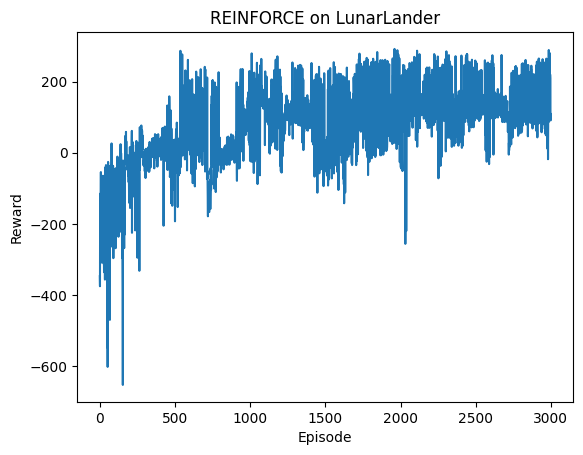

In [69]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE on LunarLander')
plt.show()